# Counting Stars

## Setup

In [22]:
#!/usr/bin/env python3

import os
import sys
import time
import pyopencl as cl
import numpy
from PIL import Image, ImageOps
from libs.util import *

In [23]:
# Suppress kernel caching.
os.environ["PYOPENCL_NO_CACHE"] = "1"
os.environ["PYOPENCL_CTX"] = "0"

In [24]:
IMG_PATH = "../images/NGC-362.jpg"
KERNEL_NAME_GREY = "kernel_grey"
KERNEL_NAME_THRESHOLD = "kernel_threshold"
KERNEL_NAME_STARS = "kernel_stars"

In [25]:
img = image_to_array(IMG_PATH)
(img_h, img_w, depth) = img.shape
print(f"Image dimensions: {img_h}x{img_w} with depth {depth}")
flat_img = img.reshape(img_h * img_w * depth).astype(numpy.uint8)

Image dimensions: 2550x2250 with depth 3


In [26]:
# Create the context, queue and program.
context = cl.create_some_context()
queue = cl.CommandQueue(context)

kernel_grey_code = open("../kernels/" + KERNEL_NAME_GREY + ".cl").read()
kernel_threshold_code = open("../kernels/" + KERNEL_NAME_THRESHOLD + ".cl").read()
kernel_stars_code = open("../kernels/" + KERNEL_NAME_STARS + ".cl").read()
program_grey = cl.Program(context, kernel_grey_code).build()
program_threshold = cl.Program(context, kernel_threshold_code).build()
program_stars = cl.Program(context, kernel_stars_code).build()


# Initialize the kernel.
kernel_grey = program_grey.kernel_grey
kernel_threshold = program_threshold.kernel_threshold
kernel_stars = program_stars.kernel_stars

## Grayscale

In [27]:
#set argument types
kernel_grey.set_scalar_arg_dtypes(
    [None, None,
        numpy.int32, numpy.int32, numpy.int32]
)

In [28]:
# Create the result image.
h_output_img = numpy.zeros(img_h * img_w * 1).astype(numpy.uint8)

# Create the buffers on the device.
d_input_img = cl.Buffer(
    context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=flat_img
)

d_output_img = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_output_img.nbytes)

In [29]:
print("Executing kernel grey...")
kernel_grey(
    queue,
    (img_h, img_w),
    None,
    d_input_img,
    d_output_img,
    img_w,
    img_h,
    depth
)
print("Done executing kernel grey.")

queue.finish()
cl.enqueue_copy(queue, h_output_img, d_output_img)
queue.flush()

Executing kernel grey...
Done executing kernel grey.


In [30]:
#save gray image
result_img = h_output_img.reshape(img_h, img_w)
save_image_grey(result_img, "../output/" + "output_" + KERNEL_NAME_GREY + ".png")

## Threshold

In [31]:
LOCAL_SIZE = 1
global_size = int((img_w * img_h)/LOCAL_SIZE)

In [32]:
kernel_threshold.set_scalar_arg_dtypes(
    [None, None,
        numpy.int32, numpy.int32]
)

In [33]:
d_input_img = cl.Buffer(
    context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_output_img
)
h_input_brightness = numpy.zeros(
    global_size).astype(numpy.uint32)

d_output_brightness = cl.Buffer(
    context, cl.mem_flags.READ_WRITE, h_input_brightness.nbytes)

In [34]:
print("Executing kernel threshold...")
kernel_threshold(
    queue,
    (global_size, 1),
    (LOCAL_SIZE, 1),
    d_output_img,
    d_output_brightness,
    img_w,
    img_h
)
print("Done executing kernel threshold.")
queue.finish()
cl.enqueue_copy(queue, h_input_brightness, d_output_brightness)
queue.flush()

Executing kernel threshold...
Done executing kernel threshold.


In [35]:
print("Brightness: ", h_input_brightness.sum())
threshold = 2 * h_input_brightness.sum()/(img_w * img_h)
threshold = math.floor(threshold)
print("the threshold is: ", threshold)

Brightness:  178625265
the threshold is:  62


## Stars

In [36]:
LOCAL_SIZE = 1
global_size = int((img_w * img_h)/LOCAL_SIZE)

In [37]:
kernel_stars.set_scalar_arg_dtypes(
    [None, None,
        numpy.int32, numpy.int32, numpy.int32]
)

In [38]:
d_input_img = cl.Buffer(
    context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_output_img
)
#h_input_count = numpy.zeros(
#    global_size).astype(numpy.uint32)
h_input_count = numpy.zeros(
    img_h * img_w).astype(numpy.uint8)
d_output_count = cl.Buffer(
    context, cl.mem_flags.READ_WRITE, h_input_count.nbytes)

In [39]:
print("Executing stars kernel...")
kernel_stars(
    queue,
    (global_size, 1),
    (LOCAL_SIZE, 1),
    d_input_img,
    d_output_count,
    threshold,
    img_w,
    img_h
)
print("Done executing stars kernel.")
queue.finish()
cl.enqueue_copy(queue, h_input_count, d_output_count)
result_img = h_input_count.reshape(img_h, img_w)
save_image_grey(result_img, "../output/" + "output_" + KERNEL_NAME_STARS + ".png")
queue.flush()

Executing stars kernel...
Done executing stars kernel.


In [40]:
print("Count: ", sum(h_input_count)/255)

Count:  10540.0


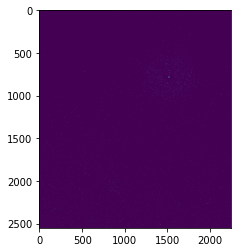

In [41]:
ngc = image_to_array("../NGC-362.result.png")
#to array
ngc = 255 - ngc
import matplotlib.pyplot as plt
plt.imshow(ngc)
plt.show()

(255,
 0,
 0.0005333333333333334,
 (array([1655, 1699, 1700, 1751, 1764, 1765, 2293, 2451, 2456, 2477, 2527,
         2532], dtype=int64),
  array([2249,    0,    0,    0, 2249, 2249, 2249, 2249, 2249, 2249,    0,
            0], dtype=int64)))

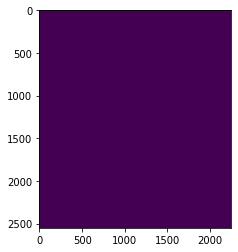

In [42]:
div = ngc - result_img
div[div!=0] = 255
plt.imshow(div)
div.max(), div.min(), div.mean(), numpy.where(div==255)

